## Imports

In [1]:
import sys
import os
import numpy as np
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.lensobject import LensObject
from gleam.utils.lensing import LensModel
from gleam.reconsrc import ReconSrc, run_model
from gleam.utils.plotting import kappa_map_plot, kappa_profiles_plot
from gleam.utils.plotting import arrival_time_surface_plot
from gleam.utils.plotting import plot_scalebar, plot_labelbox
from gleam.utils.rgb_map import radial_mask
from gleam.utils.units import H02aHz, aHz2H0, H02Gyrs, H02critdens
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()


## Load data

In [2]:
#        ACS          ACS(WFC3)        ACS(WFC3)      WFC3(UNK)
#        WFC3         SBC              WFC3           ACS(GAIA)
objs = ['B1608+656', 'DESJ0408-5354', 'HE0435-1223', 'PG1115+080',
        'RXJ0911+0551', 'RXJ1131-1231', 'SDSSJ1004+4112', 'WFIJ2033-4723']
objidx = 0
sigf = 20     #   80(20),  100(25),   60(12),  600(60),  140(35), 4000 (50),   80,   80
lens = objs[objidx]
print(lens)


B1608+656


In [3]:
fitsdir = 'data/delay_qsos/'
fitsfile = fitsdir + '{}.fits'.format(lens)
print(fitsfile)

jsondir = 'jsons/'
jsonfile = jsondir + '{}.json'.format(lens)
print(jsonfile)


data/delay_qsos/B1608+656.fits
jsons/B1608+656.json


In [4]:
with open(jsonfile) as f:
    lo = LensObject.from_json(f)
lo.squarify(0)   # 0, 0, 0, 0, 0
print(lo.__v__)


Properties of that field are unknown [None]
filename            	B1608+656.json
filepath            	/Users/phdenzel/delays/jsons/B1608+656.json
band                	
naxis1              	99
naxis2              	99
naxis_plus          	None
refval              	[242.30025957375, 65.541446346654]
refpx               	[69.5, -175.5]
center              	<242.3009, 65.5446>
px2deg              	[1.388888888888882e-05, 1.388888888888882e-05]
px2arcsec           	[0.04999999999999975, 0.04999999999999975]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x7fc294ba8e60>
roi                 	ROISelector(99, 99)
lens                	None
srcimgs             	[]
zl                  	0.63
zs                  	1.39
mapr                	2.475
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfactory         	GLSCFactory(zl, srcimgs, parity, tderr...)
finder            

In [5]:
statedir = 'states/'
statefiles = ['11doubles_dg45.state',
              '11doubles_dg60.state', '11doubles_CMB_dg60.state', '11doubles_SNeIa_dg60.state',
              '7quads_dg45.state', '7quads_CMB_dg45.state', '7quads_SNeIa_dg45.state',
              '7quads_dg60.state', '7quads_CMB_dg60.state', '7quads_SNeIa_dg60.state', 
              'all_dg60.state', 'all_SNeIa_dg60.state']
statefile = statefiles[7]  # 7  8/9 5/6
print(statefile)


7quads_dg60.state


In [6]:
lm = LensModel(statedir+statefile)
lm.obj_idx = objidx
print(lm.__v__)


filename            	7quads_dg60.state
filepath            	states/7quads_dg60.state
N                   	1000
pixrad              	8
maprad              	1.84670387036
pixel_size          	0.0434518557732
kappa               	None
minima              	[[-0.8215179170393514   1.2798384391770945 ]
 [ 1.0982397417262912   0.42373029405187596]]
saddle_points       	[[ 0.6745094476744152   1.2020104259838928 ]
 [-0.22483648255813793 -0.6399192195885473 ]]
maxima              	[]
zl                  	0.63
zs                  	1.39
N_obj               	8
N_src               	1
obj_idx             	0
src_idx             	0


In [7]:
# %%script false
qs = np.loadtxt("results/filters/7quads_dg60_B1608+656_chi2.txt")
# qs = np.loadtxt("results/filters/7quads_dg60_DESJ0408-5354_chi2.txt")
print(len(qs))


1000


In [8]:
iqs = np.argsort(qs)
iq = iqs[0]
print iq, qs[iq]

809 1.2325791319533947


In [9]:
class Measure(object):
    def __init__(self, name, mean, std=None):
        self.name = name
        self.mean = mean
        if isinstance(std, (int, float)):
            std = (-std, std)
        self.std = std
        
    def __call__(self, y=0):
        measure = [self.sig_lim[0], self.mean, self.sig_lim[1]]
        return measure, [y for i in measure]
    
    def plot(self, y=0, color=None, msize=4, xshift=0, yshift=0, lw=3, fontsize=18):
        estimate = self(y)
        plt.scatter(self.mean, y, s=msize, color=color)
        plt.plot(*estimate, lw=lw, color=color)
        plt.text(self.mean+xshift, y+yshift, self.name, color='black',
                 fontsize=fontsize, horizontalalignment='center')
        
    @property
    def sig_lims(self):
        return self.mean+self.std[0], self.mean+self.std[1]

planck = Measure(name="Planck", mean=67.4, std=0.5)  # arxiv.org/abs/1807.06209
shoes = Measure(name="SH0ES", mean=74.03, std=1.42)  # arxiv.org/abs/1903.07603
cchp = Measure(name="CCHP", mean=69.8, std=1.7)  # arxiv.org/abs/1907.05922
print(planck())


([66.9, 67.4, 67.9], [0, 0, 0])


In [10]:
H0data = np.array(lm.H0)
H0data = H0data[iqs[:300]]  # best 30%

aHzH0 = H02aHz(H0data)
invH0 = H02Gyrs(H0data)
rhocrit = H02critdens(H0data)
print(aHzH0[0])
print(invH0[0])
print(rhocrit[0])


2.460696855311345
12.935761895933169
6.07467310038713


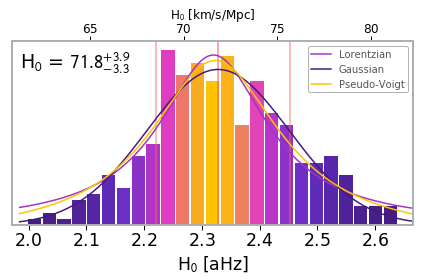

In [39]:
q = np.percentile(aHzH0, [16, 50, 84])

fig, ax = plt.subplots()
axc = ax.twiny()
# second unit axis
def convertaxc(ax):
    x1, x2 = ax.get_xlim()
    axc.set_xlim(aHz2H0(x1), aHz2H0(x2))
    axc.figure.canvas.draw()
ax.callbacks.connect("xlim_changed", convertaxc)

n, bins, patches = ax.hist(aHzH0, bins=25, density=True, rwidth=0.901)
cm = plt.cm.get_cmap('phoenix')
ax.axvline(q[1], color=gcl.pink, alpha=0.6)
ax.axvline(q[0], color=gcl.red, alpha=0.6)
ax.axvline(q[2], color=gcl.red, alpha=0.6)
yl = ax.get_ylim()

# add gaussian/lorentzian/voigt color scheme to pdf
bin_centers = 0.5 * (bins[:-1] + bins[1:])
def lorentzian(x, mu, gamma, I):
    return I/(np.pi*gamma) * gamma*gamma/((x - mu)**2 + gamma*gamma)
def gaussian(x, mu, sigma, I):
    return I/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(mu - x)**2/sigma**2)
def pseudovoigt(x, x0, sigma, gamma, eta, I):
    g = np.exp(0.5*(x-x0)**2/sigma**2)
    l = gamma*gamma / ((x-x0)**2 + gamma*gamma)
    return I*(eta*g + (1-eta)*l)
dx = bin_centers[1]-bin_centers[0]
xdata = [bin_centers[0]-i*dx for i in range(1, 16)] + list(bin_centers) + [bin_centers[-1]+i*dx for i in range(1, 16)]
ydata = [0 for i in range(15)] + list(n) + [0 for i in range(15)]
lpopt, lpcov = curve_fit(lorentzian, xdata, ydata)
ldist = lorentzian(bin_centers, lpopt[0], lpopt[1], lpopt[2])
gpopt, gpcov = curve_fit(gaussian, xdata, ydata)
gdist = gaussian(bin_centers, gpopt[0], gpopt[1], gpopt[2])
vpopt, vpcov = curve_fit(pseudovoigt, xdata, ydata)
vdist = pseudovoigt(bin_centers, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
for c, p in zip(ldist/ldist.max(), patches):
    plt.setp(p, 'facecolor', cm(c))

# add gaussian/lorentzian/voigt fits
xdata = np.linspace(xdata[0], xdata[-1], 200)
fit = lorentzian(xdata, lpopt[0], lpopt[1], lpopt[2])
ax.plot(xdata, fit, label='Lorentzian', color=cm(0.5))
fit = gaussian(xdata, gpopt[0], gpopt[1], gpopt[2])
ax.plot(xdata, fit, label='Gaussian', color=cm(0.1))
fit = pseudovoigt(xdata, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
ax.plot(xdata, fit, label='Pseudo-Voigt', color=cm(1.0))
ax.legend(loc='upper right', fontsize=10, numpoints=1, borderpad=0.3)

# # plot the values
# xmeasure = [planck, cchp, shoes]
# ymeasure = [4, 3.9, 3.8]
# for x, y, c in zip(xmeasure, ymeasure, [cm(0.25), cm(1.), cm(.5)]):
#     if x.name == 'Planck':
#         xshift = -2
#     else:
#         xshift = 0
#     x.plot(y, xshift=xshift, yshift=0.4, msize=75, color=c)
    
# add result text
plt.rcParams['mathtext.fontset'] = 'stixsans'
Hstr = 'H$_0$ = ${:5.1f}^{{{:+4.1f}}}_{{{:+4.1f}}}$'
q = np.percentile(H0data, [16, 50, 84])
plt.text(0.02, 0.85, Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]), fontsize=19, color='black', transform=plt.gca().transAxes)

fig.axes[0].get_yaxis().set_visible(False)
ax.set_xlim(bins[0]-dx, bins[-1]+dx)
# ax.set_ylim(0, 5)
ax.set_ylim(yl)
ax.set_xlabel('H$_0$ [aHz]')
axc.set_xlabel('H$_0$ [km/s/Mpc]', fontsize=12)
plt.setp(axc.get_xticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig('results/_H0hist_{}_filter{}.pdf'.format(statefile.replace('.state', ''), lens), transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
plt.show()